### The Challenge: Build a large-scale image search engine!

You and your team of **three Cornell Tech students** are surely on the path to fame and fortune! You have been recruited by Google to disrupt Google Image Search by building a better search engine using novel statistical learning techniques.

The specifications are simple: We need a way to **search for relevant images** given a natural language query. For instance, if a user types "dog jumping to catch frisbee," your system will **rank-order the most relevant images** from a large database.

---


**During training**, you have a dataset of 10,000 samples. 

Each sample has the following data available for learning:
- A 224x224 JPG image.
- A list of tags indicating objects appeared in the image.
- Feature vectors extracted using [Resnet](https://arxiv.org/abs/1512.03385), a state-of-the-art Deep-learned CNN (You don't have to train or run ResNet -- we are providing the features for you). See [here](http://ethereon.github.io/netscope/#/gist/b21e2aae116dc1ac7b50) for the illustration of the ResNet-101 architecture. The features are extracted from pool5 and fc1000 layer.
- A five-sentence description, used to train your search engine.

**During testing**, your system matches a single five-sentence description against a pool of 2,000 candidate samples from the test set. 

Each sample has:
- A 224x224 JPEG image.
- A list of tags for that image.
- ResNet feature vectors for that image.

**Output**:
For each description, your system must rank-score each testing image with the likelihood of that image matches the given sentence. Your system then returns the name of the top 20 relevant images, delimited by space. See "sample_submission.csv" on the data page for more details on the output format.

**Evaluation metric**:
There are 2,000 descriptions, and for each description, you must compare against the entire 2,000-image test set. That is, rank-order test images for each test description. We will use **MAP@20** as the evaluation metric. If the corresponding image of a description is among your algorithm's 20 highest scoring images, this metric gives you a certain score based on the ranking of the corresponding image. Please refer to the evaluation page for more details. Use all of your skills, tools, and experience. It is OK to use libraries like numpy, scikit-learn, pandas, etc., as long as you cite them. Use cross-validation on training set to debug your algorithm. Submit your results to the Kaggle leaderboard and send your complete writeup to CMS. The data you use --- and the way you use the data --- is completely up to you.

**Note**:
The best teams of **three Cornell Tech students** might use visualization techniques for debugging (e.g., show top images retrieved by your algorithm and see whether they make sense or not), preprocessing, a nice way to compare tags and descriptions, leveraging visual features and combining them with tags and descriptions, supervised and/or unsupervised learning to best understand how to best take advantage of each data source available to them.

---

**File descriptions**:

- images_train - 10,000 training images of size 224x224.
- images_test - 2,000 test images of size 224x224.
- tags_train - image tags correspond to training images. Each image have several tags indicating the human-labeled object categories appear in the image, in the form of "supercategory:category".
- tags_test - image tags correspond to test images. Each image have several tags indicating the human-labeled object categories appear in the image, in the form of "supercategory:category".
features_train - features extracted from a pre-trained Residual Network (ResNet) on training set, including 1,000 dimensional feature from classification layer (fc1000) and 2,048 dimensional feature from final convolution layer (pool5). Each dimension of the fc1000 feature corresponds to a WordNet synset here.
- features_test - features extracted from the same Residual Network (ResNet) on test set, including 1,000 dimensional feature from classification layer (fc1000) and 2,048 dimensional feature from final convolution layer (pool5).
- descriptions_train - image descriptions correspond to training images. Each image have 5 sentences for describing the image content.
- descriptions_test - image descriptions for test images. Each image have 5 sentences for describing the image content. Notice that one test description corresponds to one test image. The task you need to do is to return top 20 images in test set for each test description.
- sample_submission.csv - a sample submission file in the correct format.

---


In [1]:
import os
import sys
import csv
import operator
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.cm as cm
from matplotlib import pylab as plt


In [2]:
%matplotlib inline

In [3]:
### Read in training data

# Sort files in ascending order
def order_keys(text):
    return int(text.split('.')[0])

# Define paths
my_path = os.getcwd()
image_train_path = os.path.join(my_path, 'images_train')
desc_train_path  = os.path.join(my_path, 'descriptions_train')
tags_train_path  = os.path.join(my_path, 'tags_train')
features_train_path = os.path.join(my_path, 'features_train')


In [4]:
# Read in the training images
images_train_arr = []
image_files = os.listdir(image_train_path)
image_files.sort(key = order_keys)
for image_file in image_files:
    # Open each image file
    im = Image.open(os.path.join(image_train_path, image_file), 'r')
    
    # Convert to an np array
    images_train_arr.append(np.asarray(im))

    # Close the file
    im.close()


In [5]:
# Read in the training descriptions
desc_train_arr = []
desc_files = os.listdir(desc_train_path)
desc_files.sort(key = order_keys)
for desc_file in desc_files:
    # Open each text file. Strip leading/trailing whitespace
    lines = [line.strip() for line in open(os.path.join(desc_train_path, desc_file))]
    
    # Convert to an np array
    desc_train_arr.append(np.asarray(lines))


In [6]:
# Read in the training tags
tags_train_arr = []
tag_files = os.listdir(tags_train_path)
tag_files.sort(key = order_keys)
for tag_file in tag_files:
    # Open each text file. Strip leading/trailing whitespace
    lines = [line.strip() for line in open(os.path.join(tags_train_path, tag_file))]
    
    # Convert to an np array
    tags_train_arr.append(np.asarray(lines))


In [9]:
# Read in the training features
features_resnet1000_train_arr     = []
reader = csv.reader(open(os.path.join(features_train_path, 'features_resnet1000_train.csv')), delimiter=",")
sortedlist = sorted(reader, key = lambda row: int(row[0].split('/')[1].split('.')[0]))

# Skip the image name
for ind, image in enumerate(sortedlist):
    sortedlist[ind] = image[1:]

features_resnet1000_train_arr = sortedlist

features_resnet1000_int_train_arr = []
reader = csv.reader(open(os.path.join(features_train_path, 'features_resnet1000intermediate_train.csv')), delimiter=",")
sortedlist = sorted(reader, key = lambda row: int(row[0].split('/')[1].split('.')[0]))

# Skip the image name
for ind, image in enumerate(sortedlist):
    sortedlist[ind] = image[1:]

features_resnet1000_int_train_arr = sortedlist


In [10]:
# Add features to a dataframe
df_train = pd.DataFrame()
df_train['tag'] = tags_train_arr
df_train['image'] = images_train_arr
df_train['desciption'] = desc_train_arr
df_train['resnet_feats'] = features_resnet1000_train_arr
df_train['resnet_feats_int'] = features_resnet1000_int_train_arr


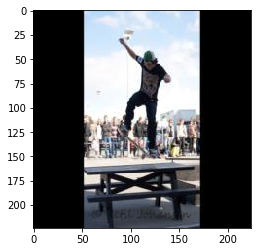

['vehicle:airplane' 'outdoor:bench' 'sports:skateboard' 'person:person'
 'vehicle:truck' 'accessory:backpack' 'accessory:handbag'
 'furniture:dining table']
['The skateboarder is putting on a show using the picnic table as his stage.'
 'A skateboarder pulling tricks on top of a picnic table.'
 'A man riding on a skateboard on top of a table.'
 'A skate boarder doing a trick on a picnic table.'
 'A person is riding a skateboard on a picnic table with a crowd watching.']
['-4.552913188934326', '-3.3393726348876953', '0.7398045063018799', '-1.0649603605270386', '-0.3858209550380707', '-1.3747957944869995', '-3.1729788780212402', '-1.2165426015853882', '-4.12231969833374', '-0.47338593006134033']
['1.0331509113311768', '0.14875449240207672', '0.046420466154813766', '0.6322464942932129', '0.19731570780277252', '0.11878049373626709', '0.0184611938893795', '0.41192910075187683', '0.37364086508750916', '0.41887933015823364']


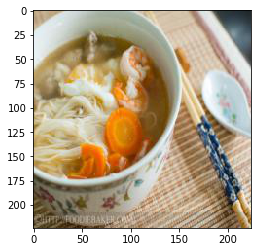

['kitchen:bowl' 'food:carrot' 'kitchen:spoon']
['A bowl of soup that has some carrots, shrimp, and noodles in it.'
 'The healthy food is in the bowl and ready to eat.'
 'Soup has carrots and shrimp in it as it sits next to chopsticks.'
 'A tasty bowl of ramen is served for someone to enjoy.'
 'Bowl of Asian noodle soup, with shrimp and carrots.']
['1.055799961090088', '1.3459196090698242', '-4.621484279632568', '-3.391326904296875', '-2.474905014038086', '-0.7654813528060913', '-3.783750057220459', '-3.479562759399414', '-0.9681328535079956', '-2.0545005798339844']
['0.23184368014335632', '0.12003348767757416', '0.09078766405582428', '2.702420949935913', '0.07832346856594086', '0.11868884414434433', '0.08248122036457062', '0.5513161420822144', '0.3491531014442444', '0.025955582037568092']


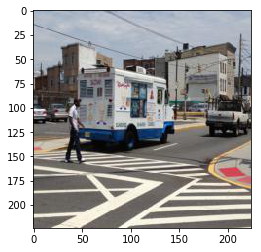

['vehicle:car' 'vehicle:truck' 'outdoor:traffic light' 'person:person']
['A man who is walking across the street.'
 'A busy intersection with an ice cream truck driving by.'
 'a man walks behind an ice cream truck'
 'A man is crossing a street near an icecream truck.'
 'The man is walking behind the concession bus.']
['-1.3230537176132202', '-1.9904590845108032', '-2.6462526321411133', '-2.5554075241088867', '0.1942424178123474', '0.3604382574558258', '-2.4502882957458496', '-1.3648340702056885', '-1.8181681632995605', '-2.428344488143921']
['0.6228247880935669', '0.25091803073883057', '0.6847997307777405', '0.3531350791454315', '0.20613180100917816', '0.3726656436920166', '0.3517184257507324', '0.36886268854141235', '0.47374072670936584', '0.6091371178627014']


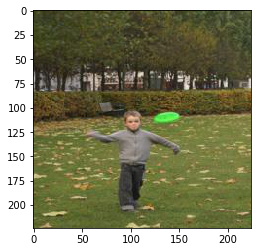

['person:person' 'outdoor:bench' 'sports:frisbee' 'vehicle:car']
['A young boy throwing a frisbee in a grassy field'
 'a young boy in the park throwing a frisbee'
 'A young boy throws a frisbee in a tree lined park.'
 'A kid in a city park throws a bright green Frisbee.'
 'A boy throwing a green frisbee in a grass field.']
['1.642971396446228', '-0.5919864773750305', '-2.0084922313690186', '-1.6832419633865356', '0.1523834466934204', '-0.5803146362304688', '-2.876101493835449', '-2.0010290145874023', '-2.138638496398926', '-0.8315469622612']
['0.2176360934972763', '0.1609954982995987', '0.19470934569835663', '0.15169507265090942', '0.8473161458969116', '0.1997891664505005', '0.06220864877104759', '0.27331846952438354', '0.41551128029823303', '0.05836094543337822']


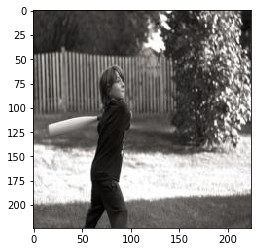

['person:person' 'sports:baseball bat']
['A young child in the yard holding up a bat.'
 'A boy raring back with a baseball bat in a yard.'
 'A little boy has a baseball bat in a yard.'
 'A boy in black clothes holds a baseball bat over his shoulder near a fence and a tree.'
 'a little boy playing in his yard with a baseball bat']
['-0.6909640431404114', '-3.6418533325195312', '-1.879539966583252', '0.20862635970115662', '0.23614682257175446', '-3.154540777206421', '-3.5946145057678223', '0.7422410249710083', '-0.4310205578804016', '-0.03661395609378815']
['0.024830954149365425', '0.13499820232391357', '0.42144355177879333', '0.007381979376077652', '0.40686696767807007', '0.02942565083503723', '0.02314169332385063', '0.6906558275222778', '0.5514852404594421', '0.0923733338713646']


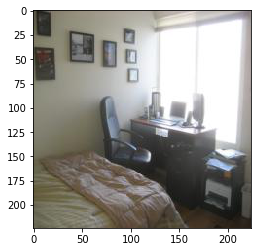

['furniture:bed' 'furniture:chair' 'electronic:mouse'
 'electronic:keyboard' 'indoor:book' 'kitchen:cup' 'electronic:tv'
 'electronic:laptop']
['A small bedroom with a desk and computer in it.'
 'A bedroom that has a desk, chair, and bed in it.'
 'A chair sitting in front of a brown desk.'
 'A desk beside a window in a bedroom'
 'a bed and a desk and chair by a big window']
['-0.2899235188961029', '-0.3310171067714691', '-3.705820083618164', '-2.944790840148926', '-1.3992842435836792', '0.3926481306552887', '-3.683743953704834', '-2.5761759281158447', '-3.1241180896759033', '-3.3433141708374023']
['0.05333779752254486', '0.6740866899490356', '0.022053053602576256', '0.05834123492240906', '0.04281541332602501', '0.23058022558689117', '0.15043498575687408', '0.5226430892944336', '0.8757483959197998', '0.08180376887321472']


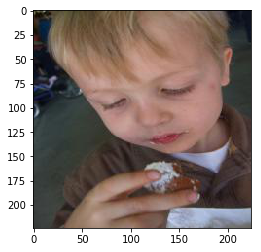

['person:person' 'food:donut' 'vehicle:bicycle']
['A small child is eating a donut fed by another hand.'
 'A blonde boy looking at his donut hole.'
 'A boy is looking at a small doughnut with powdered sugar on his face.'
 'A little boy eating powered sugar covered flood.'
 'a child eats part of a sugar frosted donut']
['2.943779706954956', '1.3723022937774658', '-0.9060096144676208', '-1.6954668760299683', '0.034152764827013016', '0.08836295455694199', '-1.2784299850463867', '-0.07398941367864609', '-0.8340699672698975', '-3.3573124408721924']
['0.13950727880001068', '0.505310595035553', '0.06782550364732742', '0.27722012996673584', '0.024405455216765404', '0.38553011417388916', '0.08771883696317673', '0.19516721367835999', '0.25375401973724365', '0.11983102560043335']


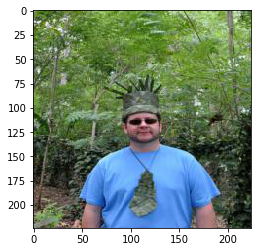

['person:person' 'accessory:tie']
['a man is standing in the woods wearing a hat and glasses'
 'A man in sunglasses wears a grass tie and hat.'
 'A man wearing a woven crown and tie.'
 'a man in a blue shirt with some weird crown'
 'a man that is standing around in a hate']
['8.063483238220215', '-0.6978402733802795', '-2.3840153217315674', '-1.6462409496307373', '-0.412574827671051', '-1.3614544868469238', '-1.5308117866516113', '-0.6421648263931274', '-0.7924115657806396', '-0.35404521226882935']
['0.5640271902084351', '0.2953871190547943', '0.06798450648784637', '0.5848069190979004', '0.40998318791389465', '0.44474107027053833', '0.34276947379112244', '0.5416949987411499', '0.6102163791656494', '0.35962119698524475']


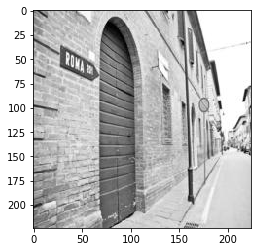

['vehicle:car' 'person:person']
['this is a street with a brick building'
 'a building with a sign and a street right outside'
 'Black and white image of an empty street.'
 'a old building that is next to a street'
 'A black and white picture of a building']
['-3.033759832382202', '-3.4561896324157715', '-1.9269770383834839', '-0.5752376914024353', '-1.0566328763961792', '-2.074120044708252', '-3.7087645530700684', '-0.3730528652667999', '-1.0943533182144165', '-1.8426235914230347']
['0.9344930648803711', '1.2361680269241333', '0.2135002762079239', '0.17959780991077423', '0.38817790150642395', '0.36978679895401', '0.1310511827468872', '0.15761618316173553', '0.6668769121170044', '0.4113936424255371']


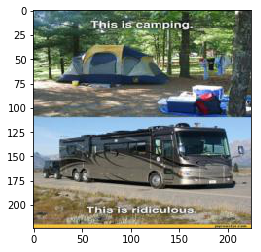

['vehicle:car' 'vehicle:bus' 'accessory:backpack']
['A tent in a forest next to a silver and brown RV.'
 'a camp site and a trailer on the road'
 'Two pictures of a tent and a bus.'
 'Two juxtaposed pictures show a tent and a motor home.'
 'There is a tent with a photo of a bus under it.']
['2.520324230194092', '-2.2599949836730957', '-5.177802085876465', '-2.7023067474365234', '-3.0699429512023926', '1.140820026397705', '-3.231300115585327', '-3.146113395690918', '-2.0587170124053955', '-0.12720546126365662']
['0.5699881315231323', '1.1872265338897705', '0.6670026183128357', '0.14910370111465454', '0.8665852546691895', '0.09007669240236282', '0.16329948604106903', '0.7532349228858948', '0.6171241998672485', '0.19931252300739288']


In [12]:
# Sanity check - print the first 10 images
for index, row in df_train.iloc[:10].iterrows():
    plt.imshow(row['image'])
    plt.show()
    print row['tag']
    print row['desciption']
    print row['resnet_feats'][:10]
    print row['resnet_feats_int'][:10]


---

In [ ]:
## OLD STUFF

# Some of the training data did not have space after punctuation and was considered together as a word
# To account for this, punctuations were replaced with a blankspace to be splitted later. The words in sentences were converted to lowercase as well
# def fixpunct(s):
#     new_sent = ''
#     for i in s:
#         if i not in string.punctuation:
#             new_sent += i
#         else:
#             new_sent += ' '
#     return new_sent.lower()


# # Iterate through the training data and generate a list of unique words
# uniquewords1 = []
# lmtzr = nltk.stem.wordnet.WordNetLemmatizer()
# for sentence in training_data1:
#     sentencefixed = fixpunct(sentence)
#     tokens = nltk.word_tokenize(sentencefixed)
#     tokens = [lmtzr.lemmatize(word, 'v') for word in tokens]
#     tokens = [word for word in tokens if word not in stopset]
#     for word in tokens:
#         if word not in uniquewords1:
#             uniquewords1.append(word)
            

In [ ]:
# Output results to CSV

# with open('test_results.csv', 'w') as csvfile:
#     writer = cimagessv.writer(csvfile, delimiter=',')
#     writer.writerow(['Description_ID','Top_20_Image_IDs'])

**Preprocessing**:
- Remove stop words
- Remove stemming
- Remove special characters 
- Lowercase everything
- https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

**Postprocessing (?)**:
- log-normalization
- l1 normalization
- l2 normalization
- Standardize the data by subtracting the mean and dividing by the variance.

**Clustering descriptions**:
- Bag of words, 2-gram, maybe PCA
- With BoW, use tf–idf
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
- https://towardsdatascience.com/natural-language-processing-count-vectorization-with-scikit-learn-e7804269bb5e

**Clustering images**:
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
- Random Decision Forests
- K-means or K-medoids
- PCA is good for reducing noise, but the input data should be "manifoldy", we are probably dealing with "clumpy"
- Niave bayes

**CNN/RNN links**:
- https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c
- http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/
- http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
- http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- https://medium.freecodecamp.org/learn-to-build-a-convolutional-neural-network-on-the-web-with-this-easy-tutorial-- 2d617ffeaef3
- https://blog.insightdatascience.com/the-unreasonable-effectiveness-of-deep-learning-representations-4ce83fc663cf
- https://papers.nips.cc/paper/5204-devise-a-deep-visual-semantic-embedding-model
- https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624
